## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-04-11 14:02:20.063849


{1: 24.8,
 5: 26.1,
 10: 26.8,
 20: 28.2,
 30: 30.3,
 40: 32.2,
 50: 34.1,
 60: 36.0,
 70: 38.0,
 80: 40.3,
 90: 43.8,
 95: 47.1,
 99: 53.1}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-04-11 13:38:48.324677


{1: 7.9,
 5: 8.0,
 10: 8.1,
 20: 8.3,
 30: 8.4,
 40: 8.5,
 50: 8.6,
 60: 8.7,
 70: 8.9,
 80: 9.0,
 90: 9.3,
 95: 9.5,
 99: 9.9}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-04-11 13:54:10.756259


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)},
 'robotics': {'pro

In [6]:
def wildeford_max_gdp_frac():
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.8:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.015, 0.8, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)

    frac = ~gdp_frac * ~percent_spent_on_compute * ~percent_spent_on_largest_model
    frac = 1 / (4*K) if frac < (1 / (4*K)) else frac
    gpd_frac = 1 / (4*K) if gdp_frac < (1 / (4*K)) else gdp_frac
    return {'total_frac': gdp_frac, 'compute_frac': frac}


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': sq.lognorm(0.75, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.norm(18.2, 19.4),  # https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'], # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 3, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 46602.14it/s]


{1: 0.0007,
 5: 0.00106,
 10: 0.00134,
 20: 0.00178,
 30: 0.0022,
 40: 0.00267,
 50: 0.00319,
 60: 0.00393,
 70: 0.005,
 80: 0.0077,
 90: 0.01175,
 95: 0.01491,
 99: 0.01981}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.07%',
 5: '0.106%',
 10: '0.134%',
 20: '0.178%',
 30: '0.22%',
 40: '0.267%',
 50: '0.319%',
 60: '0.393%',
 70: '0.5%',
 80: '0.77%',
 90: '1.175%',
 95: '1.491%',
 99: '1.981%'}

In [9]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '17.6 billion',
 5: '26.7 billion',
 10: '33.7 billion',
 20: '44.7 billion',
 30: '55.1 billion',
 40: '67.0 billion',
 50: '80.2 billion',
 60: '98.7 billion',
 70: '125.7 billion',
 80: '193.4 billion',
 90: '294.9 billion',
 95: '373.6 billion',
 99: '498.9 billion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 848740.14it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00026,
 60: 0.00038,
 70: 0.00056,
 80: 0.0009,
 90: 0.00176,
 95: 0.00293,
 99: 0.00782}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.025%',
 5: '0.025%',
 10: '0.025%',
 20: '0.025%',
 30: '0.025%',
 40: '0.025%',
 50: '0.026%',
 60: '0.038%',
 70: '0.056%',
 80: '0.09%',
 90: '0.176%',
 95: '0.293%',
 99: '0.782%'}

In [12]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6.2 billion',
 5: '6.2 billion',
 10: '6.3 billion',
 20: '6.3 billion',
 30: '6.3 billion',
 40: '6.3 billion',
 50: '6.6 billion',
 60: '9.6 billion',
 70: '14.1 billion',
 80: '22.5 billion',
 90: '44.2 billion',
 95: '73.8 billion',
 99: '196.0 billion'}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 36.6 log FLOP (~4.0 thousand decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.5 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.3 septillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~193.4 million).
* This doubles every 0.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 36.6 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 8.3 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 36.3 logFLOP which costs 17.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 35.9 logFLOP which costs 16.9 log 2025$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 35.6 logFLOP which cost

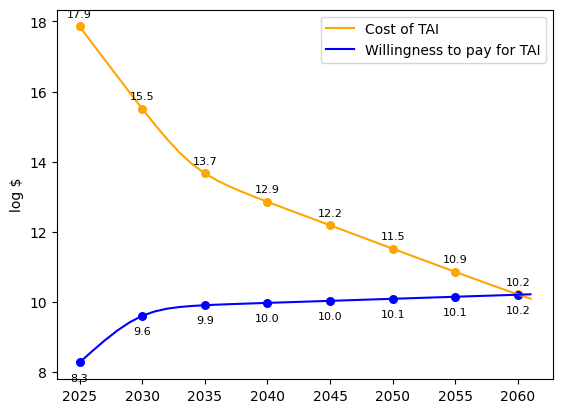



## SAMPLE RUN 2 ##

In this simulation:
* It takes 33.2 log FLOP (~1.6 decillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~20.8 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~51.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~124.4 million).
* This doubles every 2.5 year to a max of 0.042942% of GDP (initially ~10.8 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 33.2 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 8.1 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 33.0 logFLOP which costs 13.6 log 2025$USD to buy vs. WTP at 8.2 (buys 27.6 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 32.7 logFLOP which costs 13.2 log 2025$USD to buy vs. WTP at 8.3 (buys 27.8 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 32.5 logFLOP which costs 12

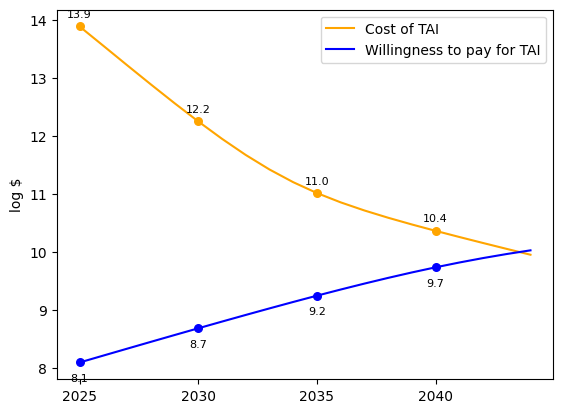



## SAMPLE RUN 3 ##

In this simulation:
* It takes 32.5 log FLOP (~316.2 nonillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.3 quintillion) per 2025$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 20.3 log FLOP (~191.7 quintillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~315.0 million).
* This doubles every 1.7 year to a max of 0.335664% of GDP (initially ~84.0 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 32.5 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 32.3 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 32.1 logFLOP which costs 13.2 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 31.9 logFLOP which cost

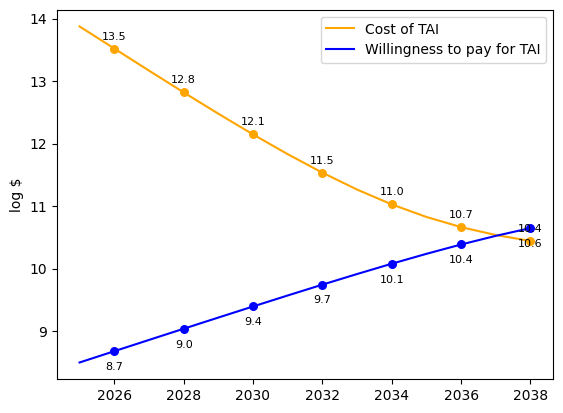



## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 301.77it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 657.37it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2031',
 '10%: 2033',
 '15%: 2035',
 '20%: 2037',
 '25%: 2039',
 '35%: 2044',
 '50%: 2054',
 '60%: 2070',
 '75%: >2125',
 '80%: >2125',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 6 years from now',
 '10%: 8 years from now',
 '15%: 10 years from now',
 '20%: 12 years from now',
 '25%: 14 years from now',
 '35%: 19 years from now',
 '50%: 29 years from now',
 '60%: 45 years from now',
 '75%: >100 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 48 years from now)


## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2026-2027: 0.5%
2028-2030: 3.6%
2030-2034: 10.7%
2035-2039: 12.3%
2040-2049: 18.1%
2050-2059: 10.8%
2060-2069: 5.5%
2070-2079: 3.8%
2080-2089: 1.4%
2090-2099: 1.3%
2100-2109: 0.8%
2110-2119:



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~26.0 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.2 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.8 trillion) 80% CI 13.4 (~26.2 trillion) - 13.4 (~27.5 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.4 trillion) 80% CI 13.4 (~26.6 trillion) - 13.5 (~28.3 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.0 trillion) 80% CI 13.4 (~27.0 trillion) - 13.5 (~29.1 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.6 trillion) 80% CI 13.4 (~27.5 trillion) - 13.5 (~29.9 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.3 trillion) 80% CI 13.4 (~27.9 trillion) - 13.5 (~30.8 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~29.9 trillion) 80% CI 13.5 (~28.3 trillion) - 13.5 (~31.7 trillion)
Year: 2034 - GDP log 2024$USD 13.

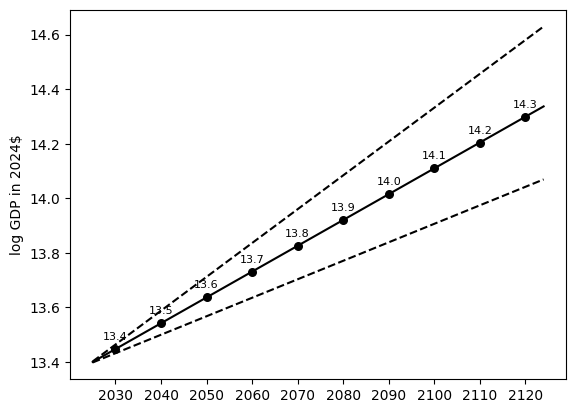

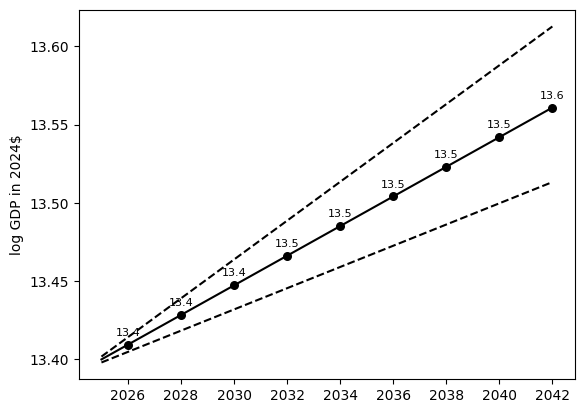



## Willingness to Pay Over Time ##
Year: 2025 - willingness log 2024$USD per year 8.6 (~375.0 million) 80% CI 8.3 (~193.4 million) - 9.0 (~956.8 million)
Year: 2026 - willingness log 2024$USD per year 8.7 (~547.9 million) 80% CI 8.5 (~323.5 million) - 9.1 (~1.3 billion)
Year: 2027 - willingness log 2024$USD per year 8.9 (~791.4 million) 80% CI 8.7 (~534.1 million) - 9.2 (~1.7 billion)
Year: 2028 - willingness log 2024$USD per year 9.1 (~1.1 billion) 80% CI 8.9 (~863.7 million) - 9.4 (~2.3 billion)
Year: 2029 - willingness log 2024$USD per year 9.2 (~1.6 billion) 80% CI 9.1 (~1.4 billion) - 9.5 (~3.0 billion)
Year: 2030 - willingness log 2024$USD per year 9.3 (~2.1 billion) 80% CI 9.3 (~2.0 billion) - 9.6 (~3.9 billion)
Year: 2031 - willingness log 2024$USD per year 9.4 (~2.8 billion) 80% CI 9.5 (~2.9 billion) - 9.7 (~5.1 billion)
Year: 2032 - willingness log 2024$USD per year 9.6 (~3.6 billion) 80% CI 9.6 (~3.8 billion) - 9.8 (~6.5 billion)
Year: 2033 - willingness log 2024$USD per y

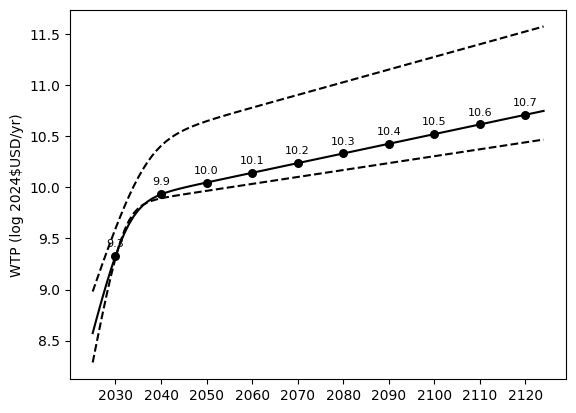

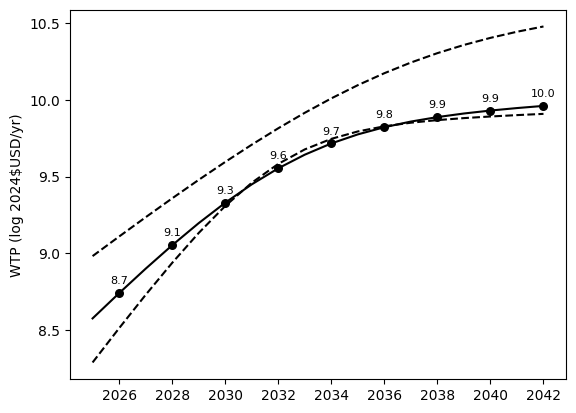



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 33.9 (~7.9 decillion) 80% CI 28.2 (~15.1 octillion) - 40.3 (~20.0 million decillion)
Year: 2026 - logFLOP needed for TAI 33.6 (~4.1 decillion) 80% CI 27.9 (~7.9 octillion) - 40.1 (~12.4 million decillion)
Year: 2027 - logFLOP needed for TAI 33.3 (~2.1 decillion) 80% CI 27.6 (~4.1 octillion) - 39.9 (~7.7 million decillion)
Year: 2028 - logFLOP needed for TAI 33.0 (~1.1 decillion) 80% CI 27.3 (~2.2 octillion) - 39.7 (~4.8 million decillion)
Year: 2029 - logFLOP needed for TAI 32.8 (~606.1 nonillion) 80% CI 27.1 (~1.2 octillion) - 39.5 (~3.0 million decillion)
Year: 2030 - logFLOP needed for TAI 32.5 (~346.7 nonillion) 80% CI 26.8 (~690.3 septillion) - 39.3 (~1.9 million decillion)
Year: 2031 - logFLOP needed for TAI 32.3 (~215.0 nonillion) 80% CI 26.6 (~427.9 septillion) - 39.1 (~1.2 million decillion)
Year: 2032 - logFLOP needed for TAI 32.2 (~148.2 nonillion) 80% CI 26.5 (~293.3 sept

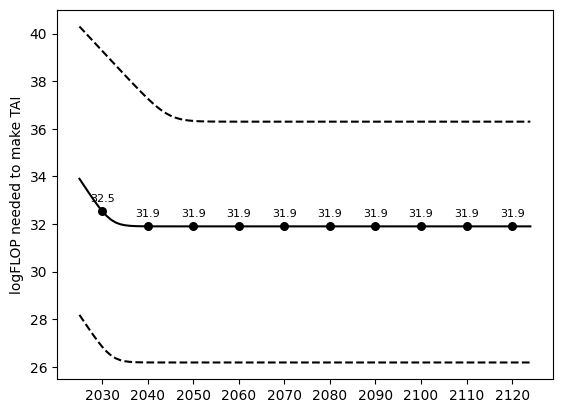

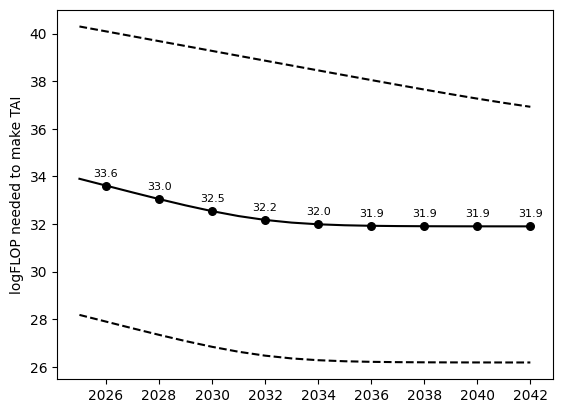



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.8 (~6.0 quintillion) 80% CI 18.5 (~3.1 quintillion) - 19.1 (~12.4 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.9 (~8.0 quintillion) 80% CI 18.6 (~4.2 quintillion) - 19.2 (~15.9 quintillion)
Year: 2027 - logFLOP per 2024$1USD 19.0 (~10.5 quintillion) 80% CI 18.8 (~5.7 quintillion) - 19.3 (~20.5 quintillion)
Year: 2028 - logFLOP per 2024$1USD 19.1 (~13.9 quintillion) 80% CI 18.9 (~7.8 quintillion) - 19.4 (~26.4 quintillion)
Year: 2029 - logFLOP per 2024$1USD 19.3 (~18.4 quintillion) 80% CI 19.0 (~10.6 quintillion) - 19.5 (~34.0 quintillion)
Year: 2030 - logFLOP per 2024$1USD 19.4 (~24.2 quintillion) 80% CI 19.2 (~14.5 quintillion) - 19.6 (~43.7 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.5 (~32.0 quintillion) 80% CI 19.3 (~19.8 quintillion) - 19.8 (~56.3 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.6 (~42.2 quintillion) 80% CI 19.4 (~26.9 quintillion) - 19.9 (~72.5 quintillion)
Year: 

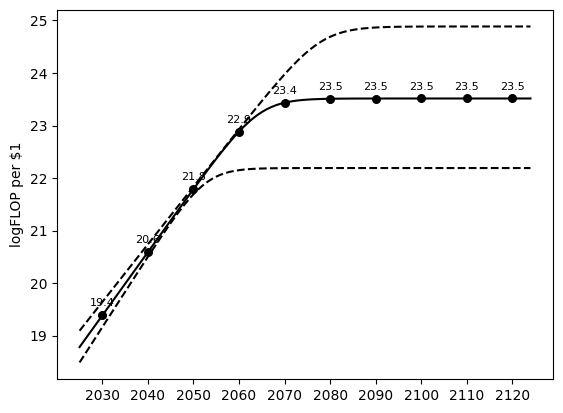

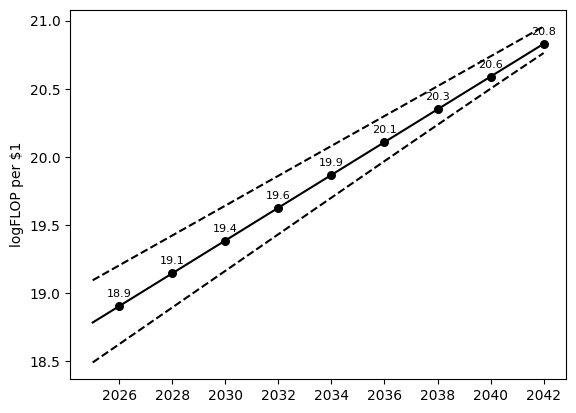



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

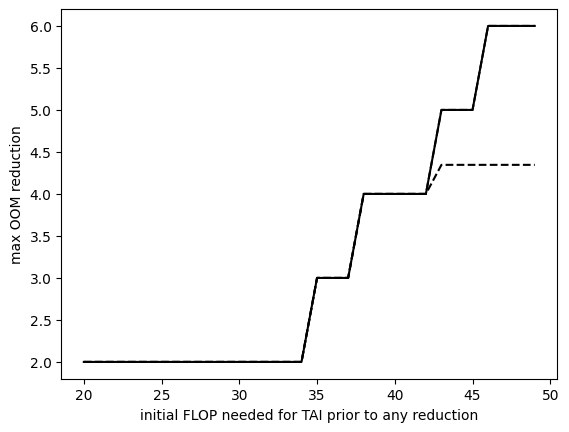



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.49yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 21 -> algo doubling rate 1.49yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 22 -> algo doubling rate 1.49yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 23 -> algo doubling rate 1.49yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 24 -> algo doubling rate 1.49yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 25 -> algo doubling rate 1.49yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 26 -> algo doubling rate 1.49yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 27 -> algo doubling rate 1.49yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 28 -> algo doubling rate 1.49yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 29 -> algo doubling rate 1.49yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 30 -> algo doubling rate 1.49yrs (80% CI: 2.18 to 2.18)
TAI log FLOP 31 -> algo doubling rate 1.02yrs (80% CI: 1.68 to 1.68)
TAI log FLOP 32 -> algo doubling rate 1.02yrs (80% CI: 1.18 to 1.18)
TAI log FLOP 33 -> algo doubling rate 1.02yrs (80%

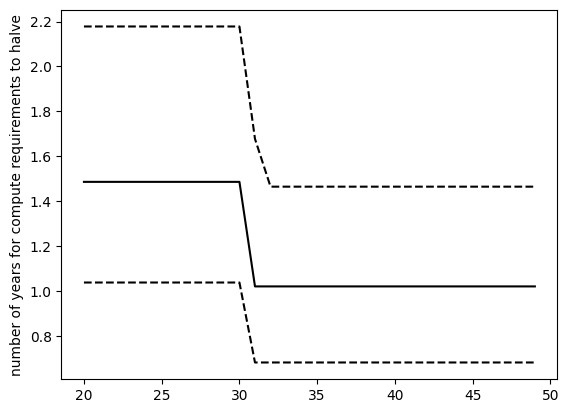



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 15.1 log 2024$USD to buy TAI (~1.3 quadrillion) 80% CI 9.7 (~4.9 billion) - 21.2 (~1.6 sextillion)
Year: 2026 - 14.7 log 2024$USD to buy TAI (~514.8 trillion) 80% CI 9.3 (~1.9 billion) - 20.9 (~781.3 quintillion)
Year: 2027 - 14.3 log 2024$USD to buy TAI (~201.7 trillion) 80% CI 8.9 (~723.5 million) - 20.6 (~378.2 quintillion)
Year: 2028 - 13.9 log 2024$USD to buy TAI (~80.3 trillion) 80% CI 8.4 (~281.8 million) - 20.3 (~183.1 quintillion)
Year: 2029 - 13.5 log 2024$USD to buy TAI (~33.0 trillion) 80% CI 8.1 (~113.0 million) - 19.9 (~88.6 quintillion)
Year: 2030 - 13.2 log 2024$USD to buy TAI (~14.3 trillion) 80% CI 7.7 (~47.6 million) - 19.6 (~42.9 quintillion)
Year: 2031 - 12.8 log 2024$USD to buy TAI (~6.7 trillion) 80% CI 7.3 (~21.7 million) - 19.3 (~20.8 quintillion)
Year: 2032 - 12.5 log 2024$USD to buy TAI (~3.5 trillion) 80% CI 7.0 (~10.9 million) - 19.0 (~10.1 quintillion)


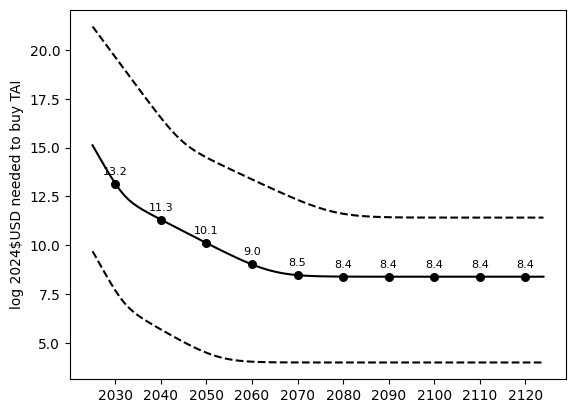

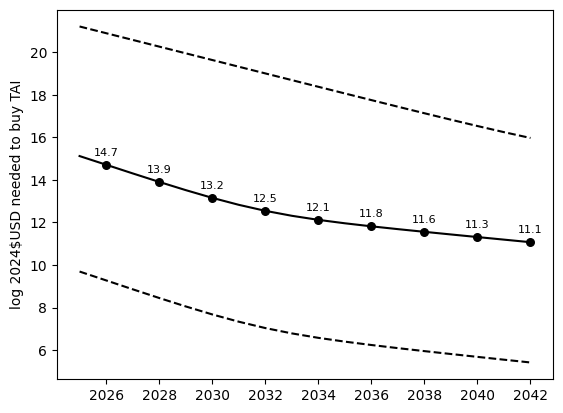



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.4 (~2.3 octillion) 80% CI 26.8 (~594.8 septillion) - 28.1 (~11.8 octillion)
Year: 2026 - max log FLOP 27.6 (~4.4 octillion) 80% CI 27.1 (~1.4 octillion) - 28.3 (~20.4 octillion)
Year: 2027 - max log FLOP 27.9 (~8.3 octillion) 80% CI 27.5 (~3.1 octillion) - 28.5 (~35.1 octillion)
Year: 2028 - max log FLOP 28.2 (~15.7 octillion) 80% CI 27.8 (~6.7 octillion) - 28.8 (~60.1 octillion)
Year: 2029 - max log FLOP 28.5 (~28.8 octillion) 80% CI 28.2 (~14.4 octillion) - 29.0 (~102.2 octillion)
Year: 2030 - max log FLOP 28.7 (~51.7 octillion) 80% CI 28.5 (~29.4 octillion) - 29.2 (~172.2 octillion)
Year: 2031 - max log FLOP 29.0 (~89.9 octillion) 80% CI 28.8 (~56.9 octillion) - 29.5 (~287.3 octillion)
Year: 2032 - max log FLOP 29.2 (~151.1 octillion) 80% CI 29.0 (~103.1 octillion) - 29.7 (~473.5 octillion)
Year: 2033 - max log FLOP 29.4 (~244.7 octillion) 80% CI 29.2 (~174.6 octillion) - 29.9 (~769.4 octillion)
Year: 2034 - max log FLOP 

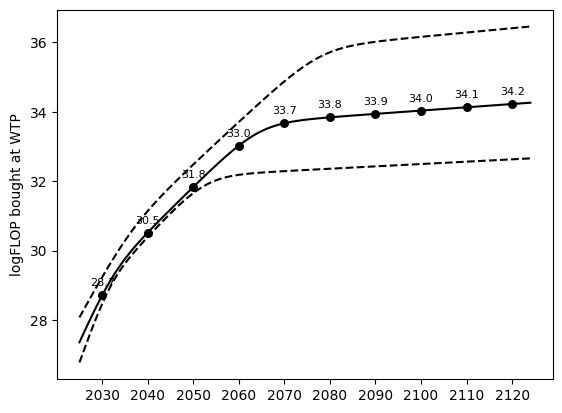

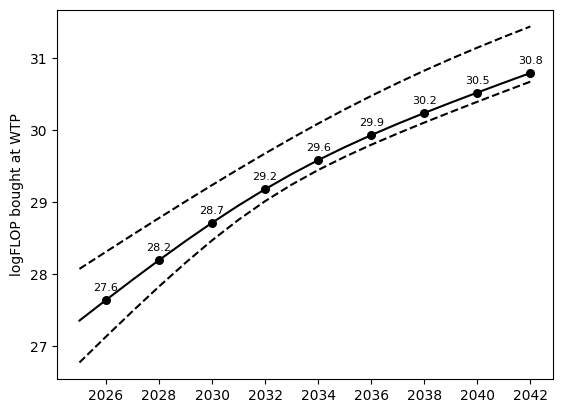



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.4 (~2.3 octillion) 80% CI 26.8 (~594.8 septillion) - 28.1 (~11.8 octillion)
Year: 2026 - max log effective 2024-FLOP 27.9 (~8.5 octillion) 80% CI 27.3 (~2.1 octillion) - 28.8 (~56.3 octillion)
Year: 2027 - max log effective 2024-FLOP 28.5 (~31.2 octillion) 80% CI 27.9 (~7.7 octillion) - 29.4 (~266.9 octillion)
Year: 2028 - max log effective 2024-FLOP 29.0 (~111.3 octillion) 80% CI 28.4 (~26.7 octillion) - 30.1 (~1.3 nonillion)
Year: 2029 - max log effective 2024-FLOP 29.6 (~377.6 octillion) 80% CI 29.0 (~89.5 octillion) - 30.8 (~5.9 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.1 (~1.2 nonillion) 80% CI 29.5 (~283.3 octillion) - 31.4 (~27.0 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.5 (~3.3 nonillion) 80% CI 29.9 (~830.3 octillion) - 32.1 (~120.9 nonillion)
Year: 2032 - max log effective 2024-FLOP 30.9 (~8.1 nonillion) 80% CI 30.3 

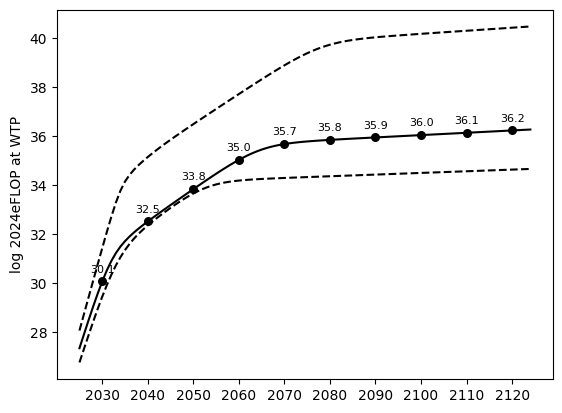

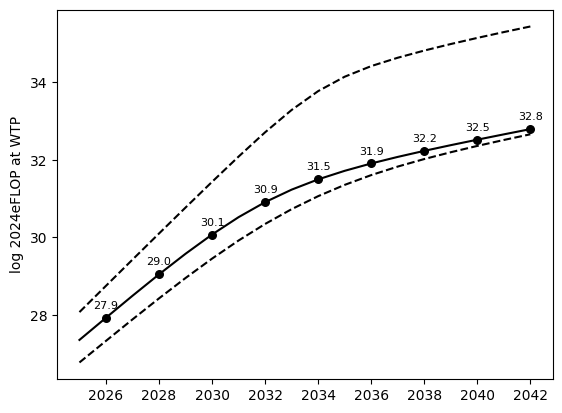


## TAI FLOP SIZE ##
{1: 24.499,
 5: 26.0,
 10: 26.790000000000003,
 20: 28.18,
 30: 30.4,
 40: 32.0,
 50: 33.9,
 60: 35.6,
 70: 37.6,
 80: 40.3,
 90: 43.910000000000004,
 95: 47.9,
 99: 55.31299999999999}


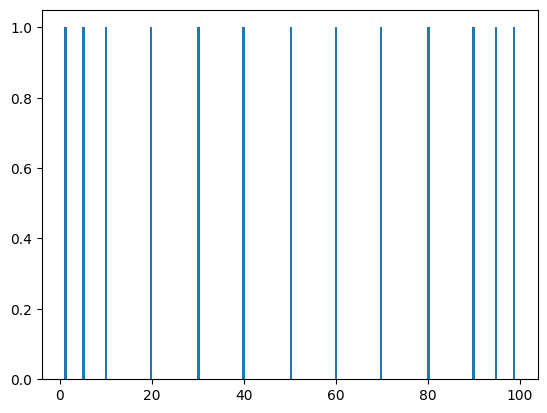



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 1.9458257596392048,
 5: 2.977850848856419,
 10: 3.418604160065148,
 20: 4.346072504843754,
 30: 5.189422085459276,
 40: 5.976906205915545,
 50: 6.586033818836607,
 60: 7.502588703573073,
 70: 8.536505353425527,
 80: 10.059561832528399,
 90: 11.845257499355593,
 95: 14.4849493417878,
 99: 20.949933508131448}


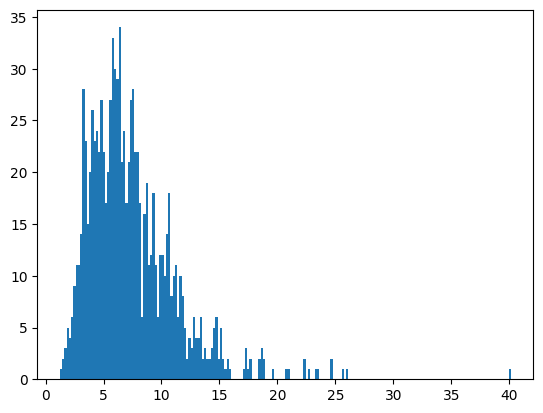



## MIN ALGO DOUBLING RATE ##
{1: 0.3831458059398139,
 5: 0.4852098045149904,
 10: 0.5620184693237422,
 20: 0.6834359032208621,
 30: 0.7963739856358703,
 40: 0.8981847491253925,
 50: 1.0217678644697719,
 60: 1.131804845729528,
 70: 1.2748489124487932,
 80: 1.4654399458519936,
 90: 1.7760120578268737,
 95: 2.0119659628273525,
 99: 2.701462929482853}


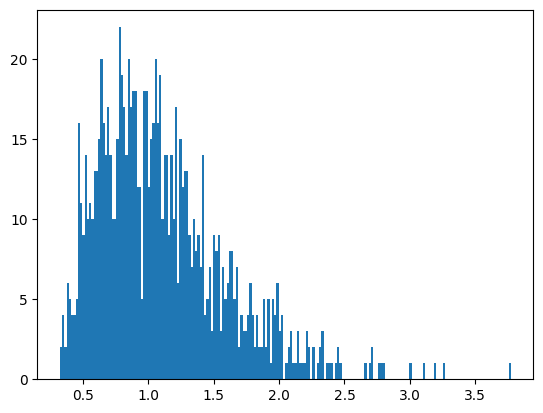



## MAX ALGO DOUBLING RATE ##
{1: 0.5873850212961422,
 5: 0.735315597826095,
 10: 0.8353195468570306,
 20: 1.0391166486561512,
 30: 1.174301001340662,
 40: 1.3139943540381183,
 50: 1.4868136803442922,
 60: 1.6928629989388684,
 70: 1.892284376602113,
 80: 2.1779505883089088,
 90: 2.5979553116170493,
 95: 3.0016892670005917,
 99: 4.16500842889525}


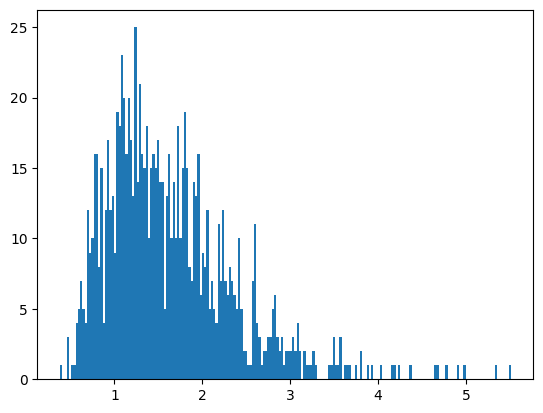



## INITIAL FLOP PER DOLLAR ##
{1: 17.949423603846697,
 5: 18.181971642599777,
 10: 18.331623558421004,
 20: 18.488066063553052,
 30: 18.60040673724555,
 40: 18.69158620995568,
 50: 18.78167468437367,
 60: 18.877222071872506,
 70: 18.974444601903464,
 80: 19.092113860199852,
 90: 19.250881703133633,
 95: 19.370859520613863,
 99: 19.611608310130453}


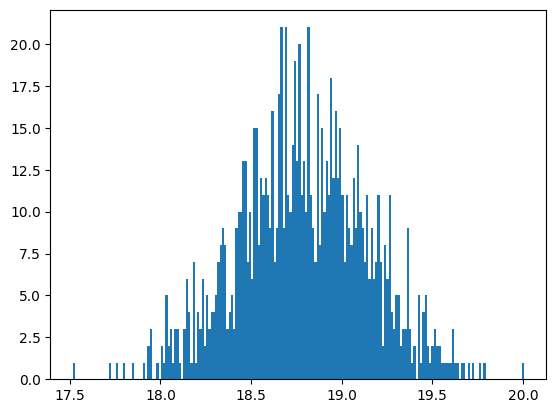



## FLOP HALVING RATE ##
{1: 1.7700228361335568,
 5: 1.9723633397050049,
 10: 2.102933535572059,
 20: 2.2343842736118322,
 30: 2.3411524708634337,
 40: 2.4196769869672523,
 50: 2.4976300635576374,
 60: 2.5617638515824983,
 70: 2.6567285419401037,
 80: 2.743637825931127,
 90: 2.846692026091195,
 95: 2.9557836320199526,
 99: 3.17320485954833}


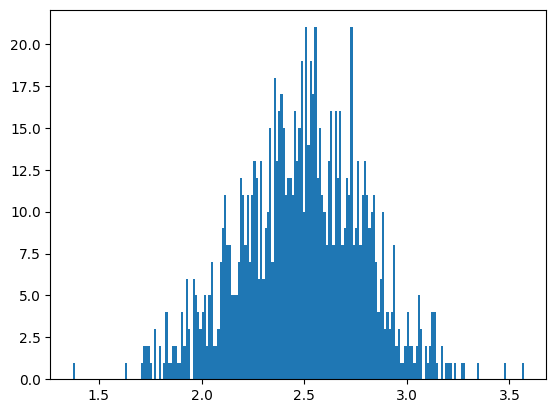



## MAX FLOP PER DOLLAR ##
{1: 20.1517248799846,
 5: 21.078289123952025,
 10: 21.555553169236838,
 20: 22.190223254200617,
 30: 22.70252893665887,
 40: 23.103442861457644,
 50: 23.51463320046954,
 60: 23.976553975220884,
 70: 24.40541439303472,
 80: 24.88580594096825,
 90: 25.538728754822376,
 95: 25.981610978261553,
 99: 27.139828201756604}


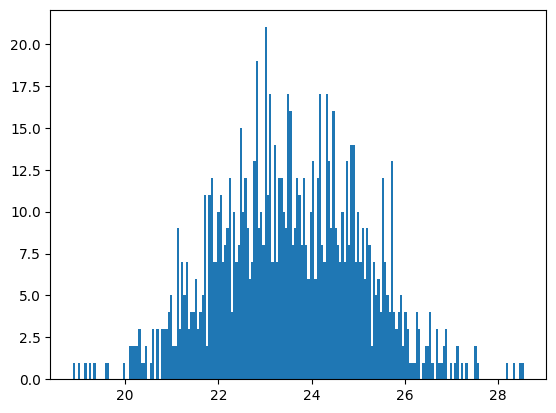



## INITIAL PAY ##
{1: 7.9,
 5: 8.0,
 10: 8.2,
 20: 8.3,
 30: 8.4,
 40: 8.5,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 9.0,
 90: 9.3,
 95: 9.5,
 99: 9.9}


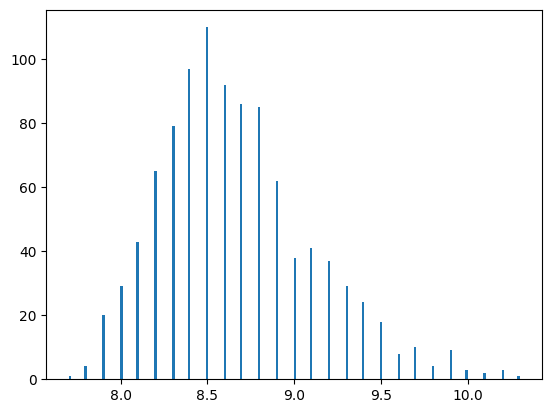



## INITIAL GDP ##
{1: 24804131060880.543,
 5: 24901626754445.2,
 10: 24950499716109.914,
 20: 25008490028156.74,
 30: 25045554647205.547,
 40: 25079734769742.766,
 50: 25121456810379.062,
 60: 25152604160880.85,
 70: 25185075884685.086,
 80: 25226425984095.438,
 90: 25278878703691.04,
 95: 25323702997550.484,
 99: 25384833627254.242}


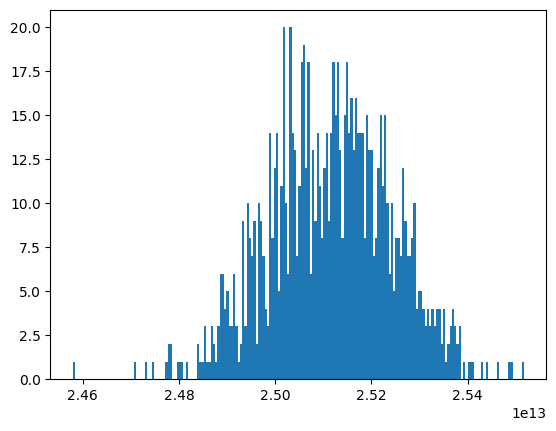



## GDP GROWTH ##
{1: 1.0057350635676532,
 5: 1.0093475171168036,
 10: 1.0126485846819826,
 20: 1.0157292320079556,
 30: 1.0181951548273933,
 40: 1.0199709189210222,
 50: 1.022026739472683,
 60: 1.0240694837733055,
 70: 1.0263312605833712,
 80: 1.0289718502522711,
 90: 1.032164110207334,
 95: 1.034852105688538,
 99: 1.0402583101161826}


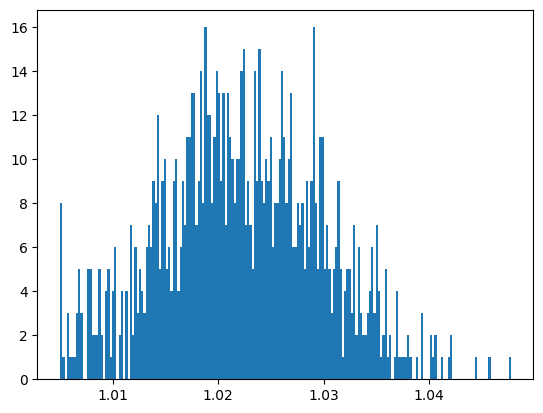



## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.0002573925266046252,
 60: 0.00035422010015385665,
 70: 0.0005365622305373083,
 80: 0.0008782382998229046,
 90: 0.001660267114956922,
 95: 0.002947132407041039,
 99: 0.00939577440525892}


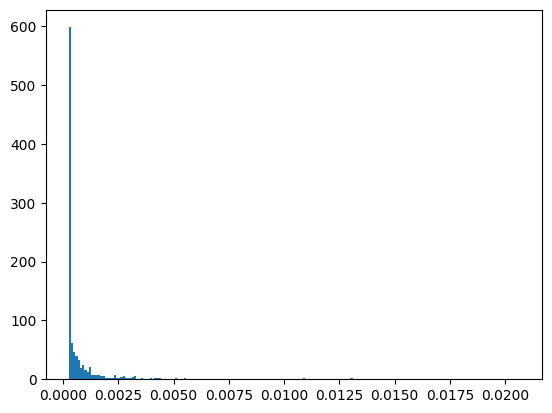



## SPEND DOUBLING TIME ##
{1: 0.9,
 5: 0.9966547327267201,
 10: 1.1044083298391978,
 20: 1.2943048280045193,
 30: 1.4431370692548076,
 40: 1.572781583234193,
 50: 1.707746577979663,
 60: 1.8576846241494136,
 70: 2.03134195228875,
 80: 2.253134793537654,
 90: 2.5772596817200606,
 95: 2.937531721956606,
 99: 3.586179852048929}


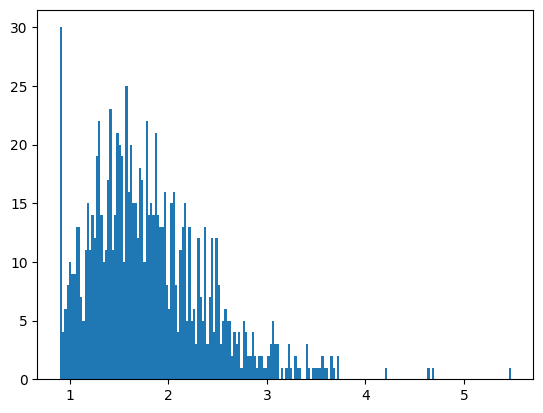





## Nonscaling delay ##
There are 7 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 2,
 5: 2,
 10: 2,
 20: 3,
 30: 3,
 40: 3,
 50: 3,
 60: 4,
 70: 4,
 80: 4,
 90: 5,
 95: 7,
 99: 17}
## Chance of nonscaling delay ##


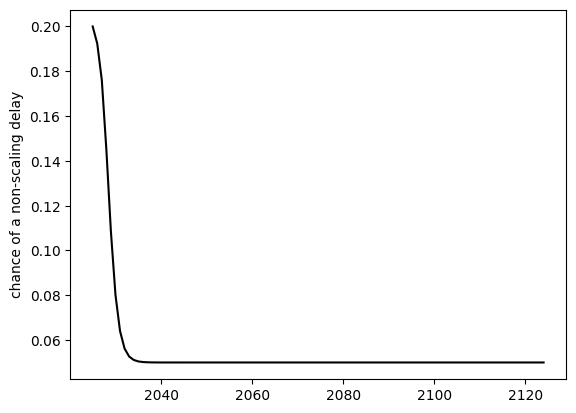

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - ch

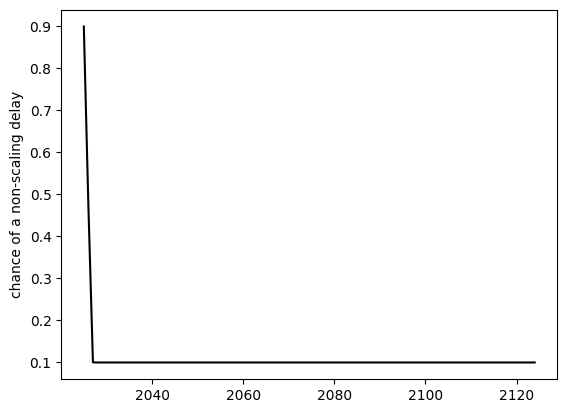

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

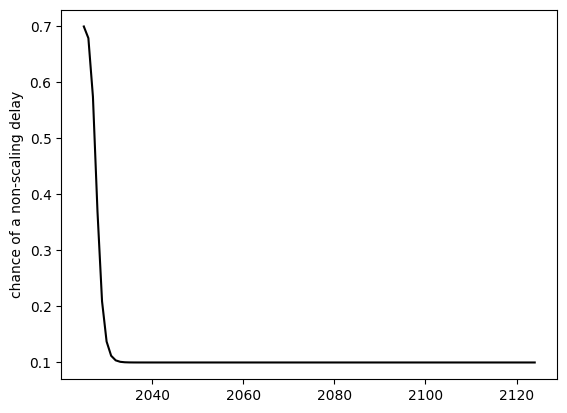

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

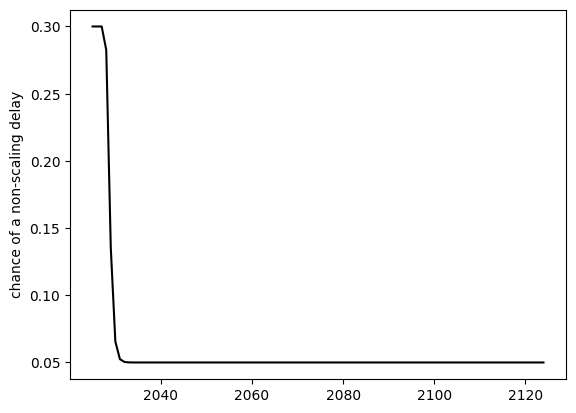

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - ch

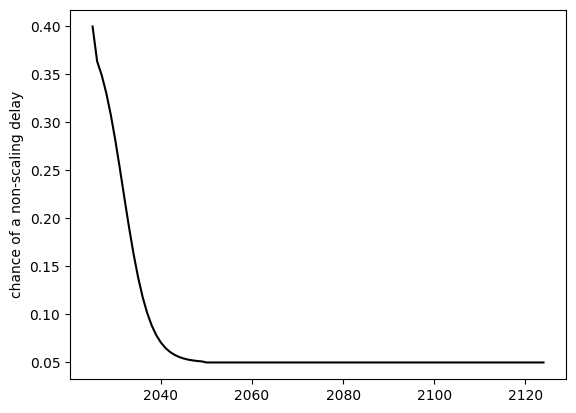

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 36%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 35%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 33%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 31%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2035

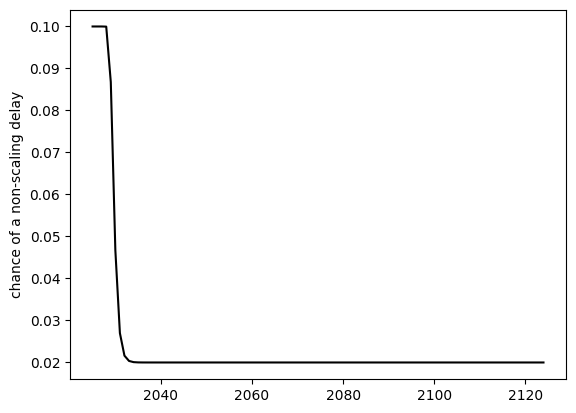

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 3%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2035 - cha

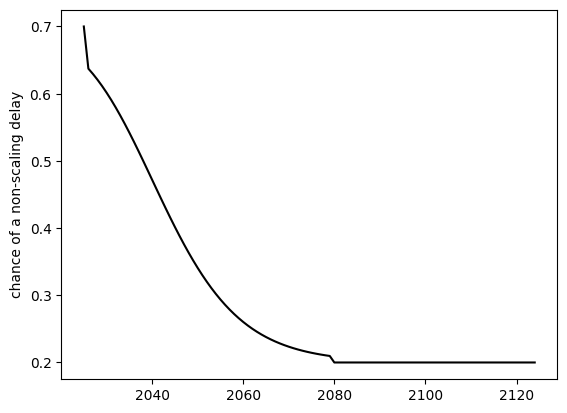

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 64%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 63%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 62%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 61%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 55%
Year: 2035

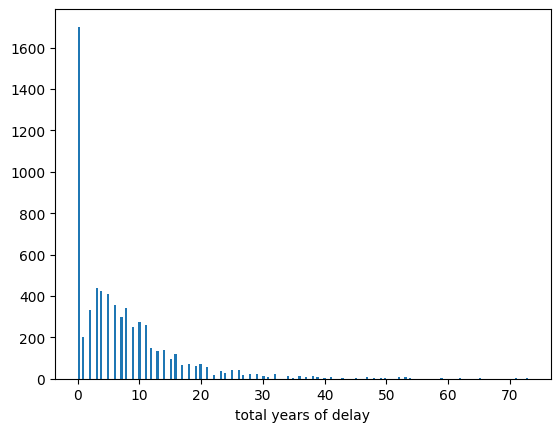

In [13]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 36.0 log FLOP (~1.0 thousand decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.3 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~14.4 septillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~124.8 million).
* This doubles every 2.7 year to a max of 0.056102% of GDP (initially ~14.1 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 36.0 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 8.1 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 35.7 logFLOP which costs 16.7 log 2025$USD to buy vs. WTP at 8.2 (buys 27.2 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 35.4 logFLOP which costs 16.3 log 2025$USD to buy vs. WTP at 8.3 (buys 27.4 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 35.1 logFLOP whi

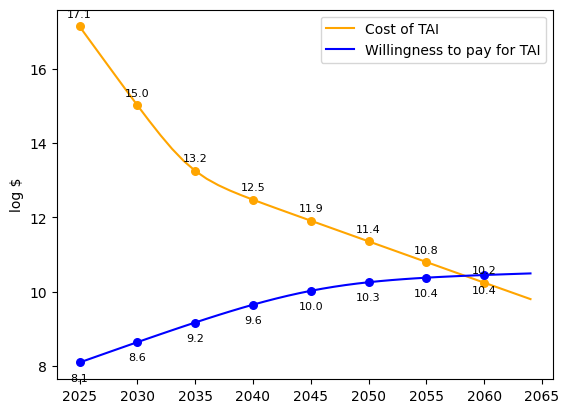

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 26.6 log FLOP (~398.1 septillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.8 log FLOP (~65.3 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.5 septillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~154.6 million).
* This doubles every 1.2 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 26.6 logFLOP which costs 6.8 log 2025$USD to buy vs. WTP at 8.2 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Nons

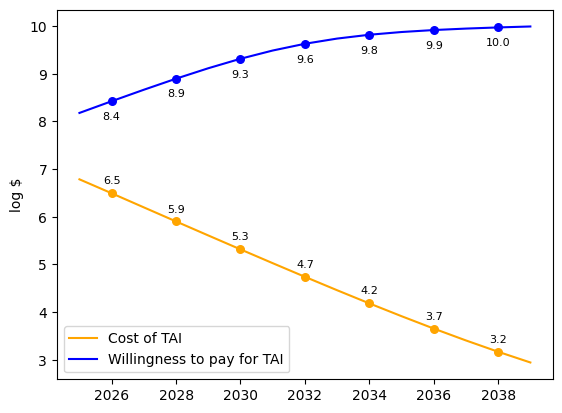

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 28.3 log FLOP (~20.0 octillion) for transformative capabilities.
* Every 2.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.8 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~626.0 million).
* This doubles every 1.5 year to a max of 0.315893% of GDP (initially ~79.9 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 28.3 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 28.2 logFLOP which costs 9.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 28.1 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1761 -> N

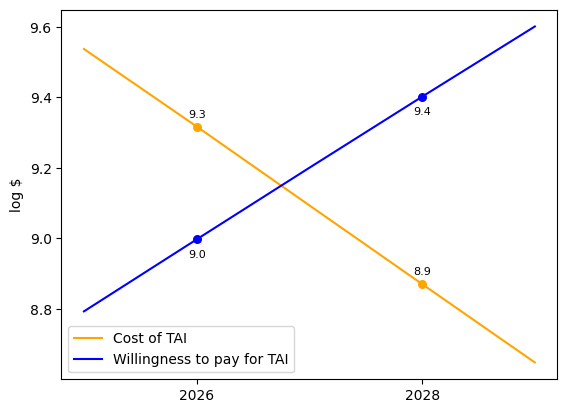

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 36.2 log FLOP (~1.6 thousand decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~139.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~3.7 billion).
* This doubles every 1.3 year to a max of 0.036764% of GDP (initially ~9.2 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 36.2 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 9.4 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 36.0 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 9.6 (buys 28.0 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 35.8 logFLOP which costs 17.2 log 2025$USD to buy vs. WTP at 9.7 (buys 28.3 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 35.6 logFLOP which

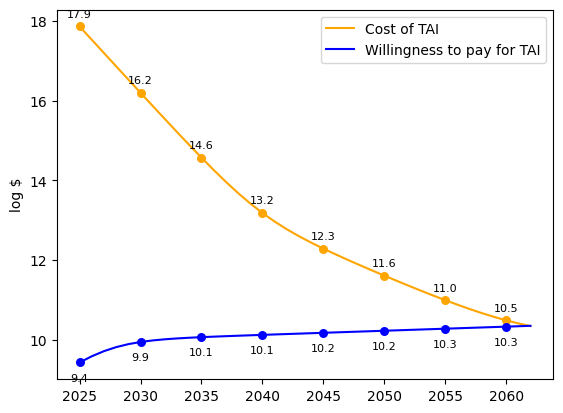

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 38.5 log FLOP (~316.2 thousand decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.1 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~2.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~4.9 billion).
* This doubles every 1.0 year to a max of 0.088173% of GDP (initially ~22.2 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 38.5 logFLOP which costs 20.0 log 2025$USD to buy vs. WTP at 9.6 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 38.2 logFLOP which costs 19.5 log 2025$USD to buy vs. WTP at 9.8 (buys 28.5 log FLOP or 28.8 2025-log-eFLOP)
2027 - TAI takes 37.8 logFLOP which costs 19.1 log 2025$USD to buy vs. WTP at 10.0 (buys 28.8 log FLOP or 29.5 2025-log-eFLOP)
2028 - TAI takes 37.5 logFLOP whi

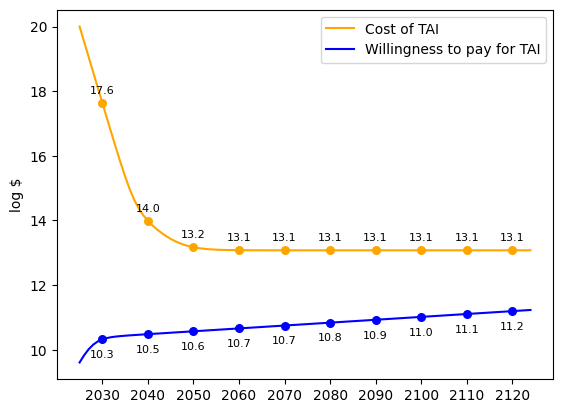

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 29.7 log FLOP (~501.2 octillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 26.4 log FLOP (~254.8 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~2.1 billion).
* This doubles every 1.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 29.7 logFLOP which costs 11.0 log 2025$USD to buy vs. WTP at 9.2 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 29.6 logFLOP which costs 10.7 log 2025$USD to buy vs. WTP at 9.3 (buys 28.2 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 29.4 logFLOP which costs 10.4 log 2025$USD to buy vs. WTP at 9.4 (buys 28.4 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 29.3 logFLOP which costs 10.

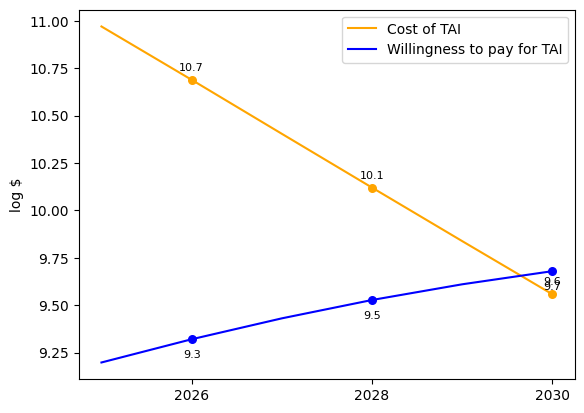

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 40.5 log FLOP (~31.6 million decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2.4 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~14.6 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~416.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~374.5 million).
* This doubles every 1.6 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 40.5 logFLOP which costs 21.3 log 2025$USD to buy vs. WTP at 8.5 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 40.3 logFLOP which costs 21.0 log 2025$USD to buy vs. WTP at 8.7 (buys 28.0 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 40.0 logFLOP which costs 20.6 log 2025$USD to buy vs. WTP at 8.9 (buys 28.3 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 39.8 logFLOP wh

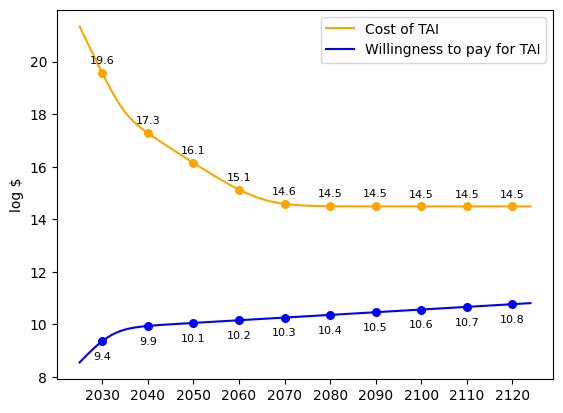

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 27.1 log FLOP (~1.3 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.6 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~161.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 1.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 27.1 logFLOP which costs 8.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 6 years)
-- 

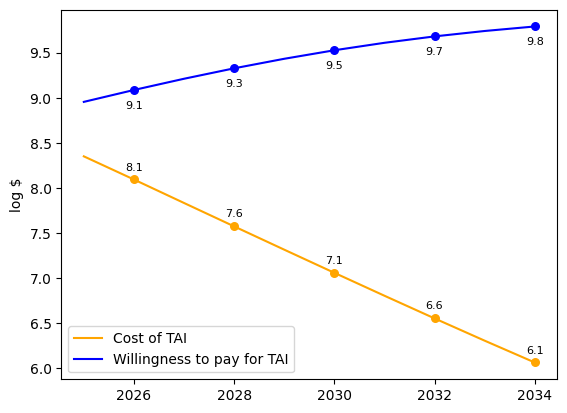

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 35.7 log FLOP (~501.2 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.7 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~134.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~395.5 million).
* This doubles every 1.2 year to a max of 0.243911% of GDP (initially ~61.4 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 35.7 logFLOP which costs 16.8 log 2025$USD to buy vs. WTP at 8.6 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 35.4 logFLOP which costs 16.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 35.1 logFLOP which costs 16.0 log 2025$USD to buy vs. WTP at 9.1 (buys 28.3 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 34.8 logFLOP which co

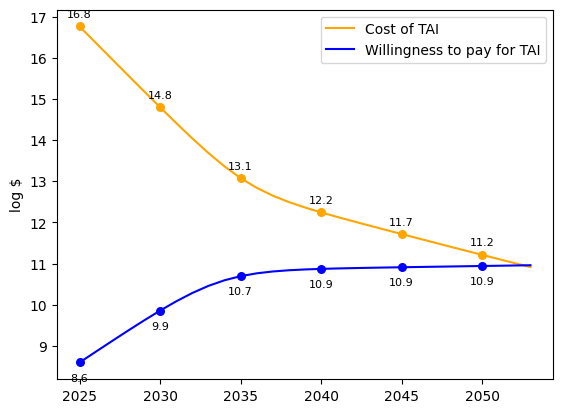

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 27.7 log FLOP (~5.0 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~28.1 quintillion) per 2025$USD.
* Every 3.2 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~176.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 2.0 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 27.7 logFLOP which costs 8.3 log 2025$USD to buy vs. WTP at 9.0 (buys 28.4 log FLOP or 28.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 5 years)
--

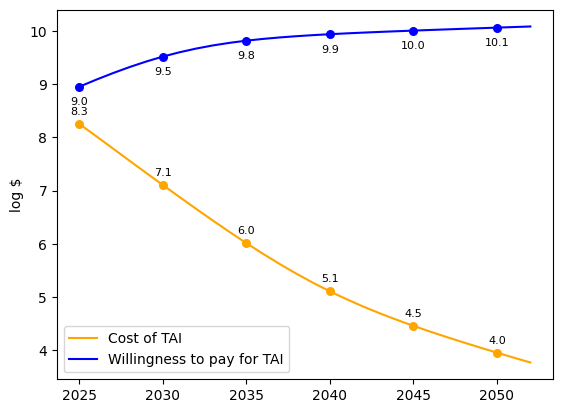

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 33.5 log FLOP (~3.2 decillion) for transformative capabilities.
* Every 2.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.1 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 20.4 log FLOP (~264.1 quintillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~156.0 million).
* This doubles every 1.2 year to a max of 0.039665% of GDP (initially ~9.9 billion 2025$USD).
* GDP grows at a rate of 1.009x per year.
---
2025 - TAI takes 33.5 logFLOP which costs 14.7 log 2025$USD to buy vs. WTP at 8.2 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 33.4 logFLOP which costs 14.5 log 2025$USD to buy vs. WTP at 8.4 (buys 27.3 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 33.2 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 8.7 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 33.1 logFLOP which cost

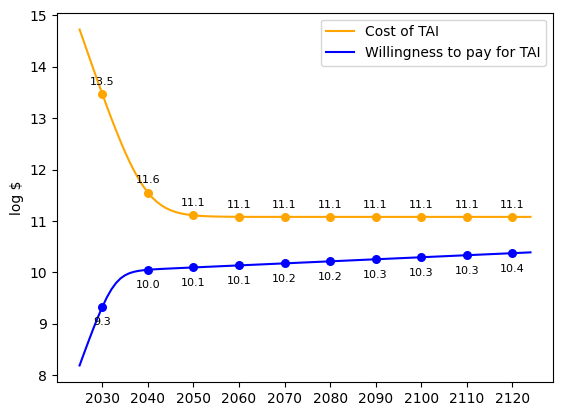

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 45.3 log FLOP (~2.0 trillion decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~14.1 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~35.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~705.2 million).
* This doubles every 0.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 45.3 logFLOP which costs 26.2 log 2025$USD to buy vs. WTP at 8.8 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 44.9 logFLOP which costs 25.7 log 2025$USD to buy vs. WTP at 9.1 (buys 28.4 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 44.6 logFLOP which costs 25.2 log 2025$USD to buy vs. WTP at 9.3 (buys 28.7 log FLOP or 29.5 2025-log-eFLOP)
2028 - TAI takes 44.2 logFLOP which 

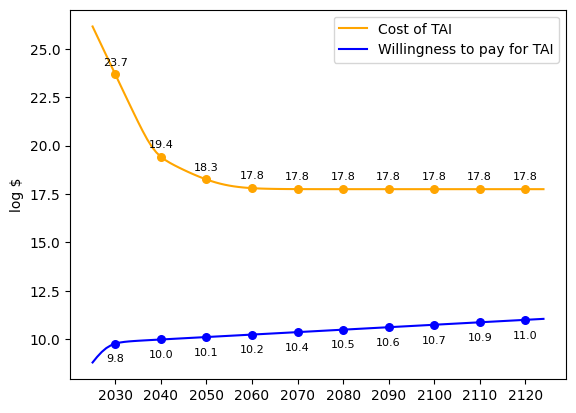

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 39.3 log FLOP (~2.0 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.6 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.4 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~464.3 million).
* This doubles every 2.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 39.3 logFLOP which costs 20.2 log 2025$USD to buy vs. WTP at 8.6 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 38.9 logFLOP which costs 19.6 log 2025$USD to buy vs. WTP at 8.8 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 38.4 logFLOP which costs 19.1 log 2025$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 38.0 logFLOP which c

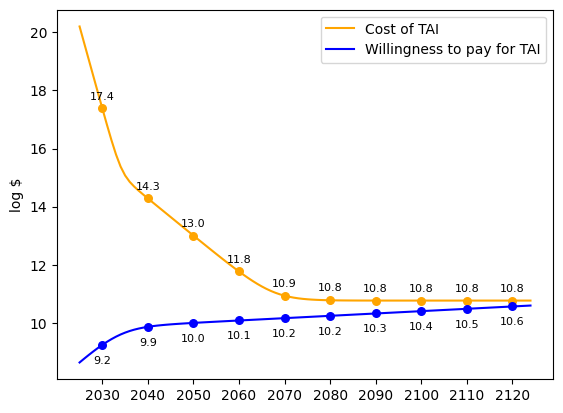

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 29.7 log FLOP (~501.2 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.0 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~334.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~374.6 million).
* This doubles every 2.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 29.7 logFLOP which costs 10.7 log 2025$USD to buy vs. WTP at 8.5 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 29.6 logFLOP which costs 10.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.8 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 29.4 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 8.8 (buys 28.1 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 29.3 logFLOP which costs 

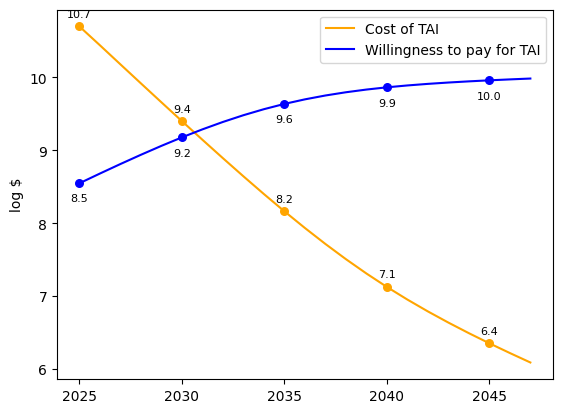

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 42.2 log FLOP (~1.6 billion decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~4.7 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~918.0 million).
* This doubles every 1.4 year to a max of 0.044815% of GDP (initially ~11.2 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 42.2 logFLOP which costs 23.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 41.9 logFLOP which costs 23.0 log 2025$USD to buy vs. WTP at 9.1 (buys 28.0 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 41.5 logFLOP which costs 22.5 log 2025$USD to buy vs. WTP at 9.3 (buys 28.3 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 41.2 logFLOP whic

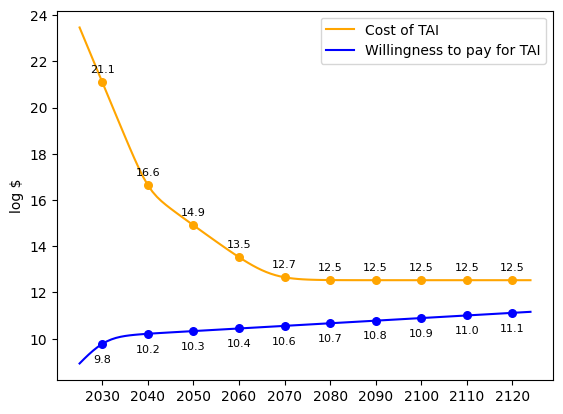

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 43.7 log FLOP (~50.1 billion decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.8 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~9.1 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~374.1 million).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.009x per year.
---
2025 - TAI takes 43.7 logFLOP which costs 24.7 log 2025$USD to buy vs. WTP at 8.5 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 43.4 logFLOP which costs 24.2 log 2025$USD to buy vs. WTP at 8.7 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 43.0 logFLOP which costs 23.8 log 2025$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 42.7 logFLOP which 

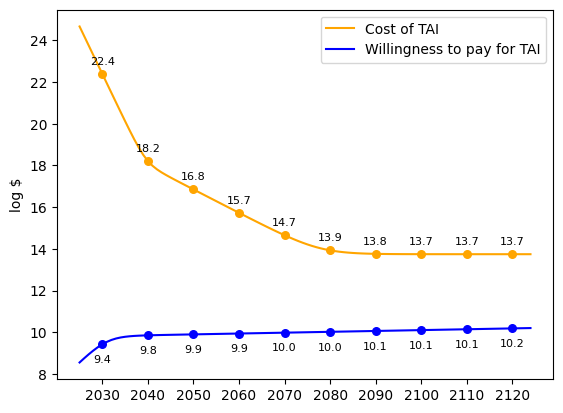

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 31.9 log FLOP (~79.4 nonillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.0 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 19.4 log FLOP (~23.1 quintillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~301.0 million).
* This doubles every 3.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 31.9 logFLOP which costs 13.2 log 2025$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 31.6 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 8.5 (buys 27.3 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 31.3 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.5 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 31.0 logFLOP which costs 1

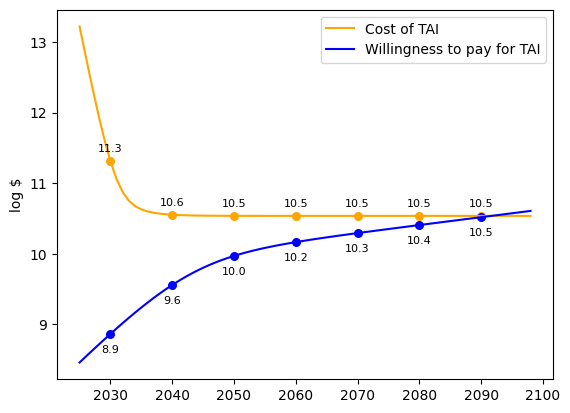

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 28.7 log FLOP (~50.1 octillion) for transformative capabilities.
* Every 2.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.5 million).
* This doubles every 1.0 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 28.7 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 8.4 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 28.6 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 8.6 (buys 27.5 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 28.5 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 28.3 logFLOP which costs 9.2 

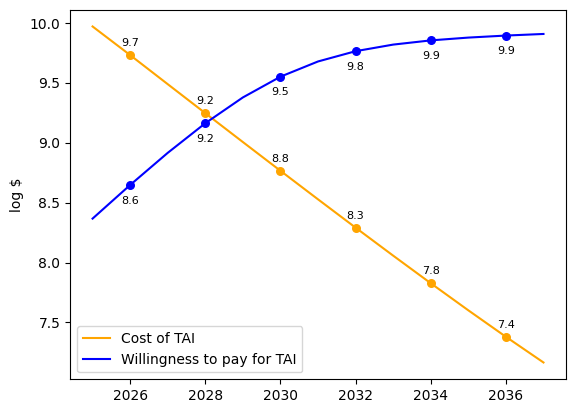

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 33.5 log FLOP (~3.2 decillion) for transformative capabilities.
* Every 2.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.1 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~4.6 septillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~3.8 billion).
* This doubles every 2.1 year to a max of 0.06105% of GDP (initially ~15.1 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 33.5 logFLOP which costs 14.6 log 2025$USD to buy vs. WTP at 9.5 (buys 28.3 log FLOP or 28.3 2025-log-eFLOP)
2026 - TAI takes 33.4 logFLOP which costs 14.4 log 2025$USD to buy vs. WTP at 9.6 (buys 28.6 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 33.3 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 9.7 (buys 28.8 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 33.1 logFLOP which costs 13.

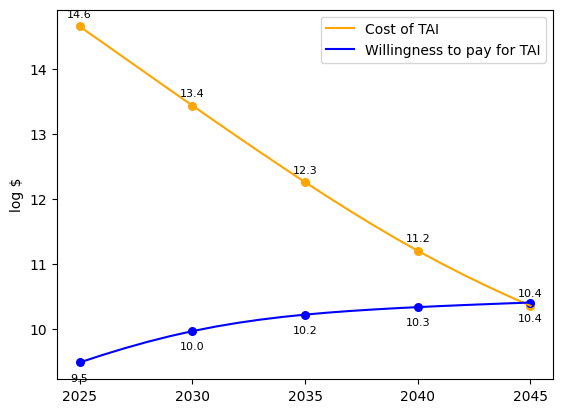

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 38.1 log FLOP (~125.9 thousand decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~15.0 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~32.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~4.6 billion).
* This doubles every 1.8 year to a max of 0.212637% of GDP (initially ~53.7 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 38.1 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 9.6 (buys 28.8 log FLOP or 28.8 2025-log-eFLOP)
2026 - TAI takes 37.8 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 9.8 (buys 29.1 log FLOP or 29.4 2025-log-eFLOP)
2027 - TAI takes 37.5 logFLOP which costs 18.0 log 2025$USD to buy vs. WTP at 9.9 (buys 29.4 log FLOP or 30.0 2025-log-eFLOP)
2028 - TAI takes 37.2 logFLOP w

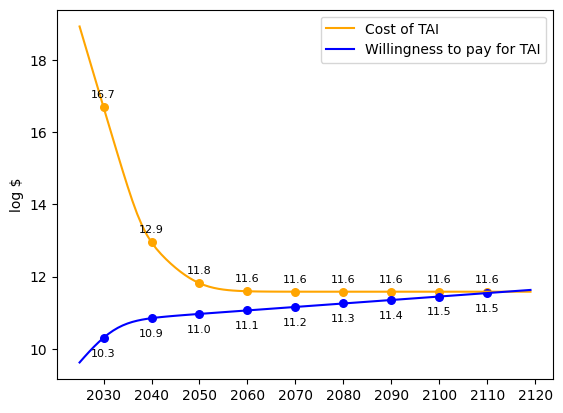

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 27.8 log FLOP (~6.3 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.0 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~540.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.1 billion).
* This doubles every 1.5 year to a max of 0.048692% of GDP (initially ~12.1 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 27.8 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 4 years)

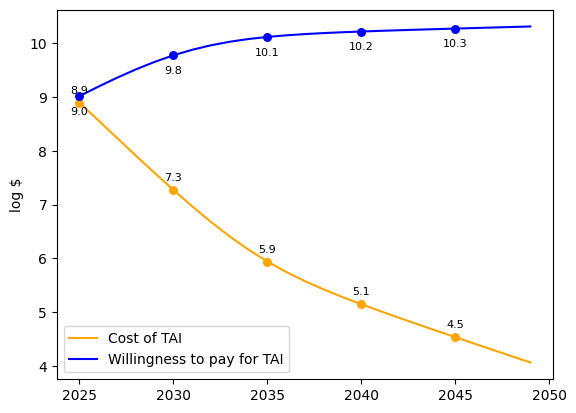

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 28.7 log FLOP (~50.1 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.7 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.3 log FLOP (~17.9 septillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~193.4 million).
* This doubles every 1.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 28.7 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 8.3 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 28.5 logFLOP which costs 9.8 log 2025$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 28.3 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 28.0 logFLOP which costs 9.1 

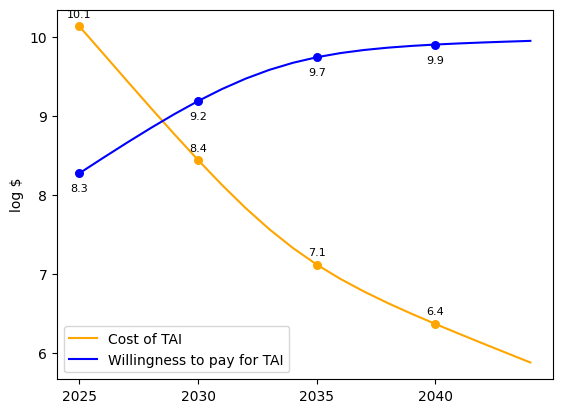

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 35.8 log FLOP (~631.0 decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.3 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~24.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~384.8 million).
* This doubles every 1.1 year to a max of 0.045532% of GDP (initially ~11.5 billion 2025$USD).
* GDP grows at a rate of 1.006x per year.
---
2025 - TAI takes 35.8 logFLOP which costs 16.9 log 2025$USD to buy vs. WTP at 8.6 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 35.5 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 35.2 logFLOP which costs 16.2 log 2025$USD to buy vs. WTP at 9.1 (buys 28.2 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 35.0 logFLOP which cos

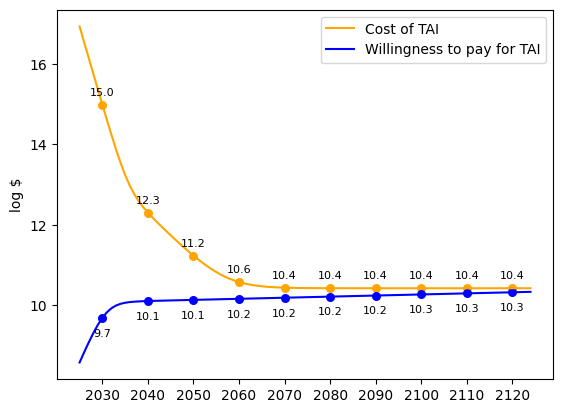

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 37.3 log FLOP (~20.0 thousand decillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~17.0 septillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~154.6 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 37.3 logFLOP which costs 19.0 log 2025$USD to buy vs. WTP at 8.2 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 37.1 logFLOP which costs 18.7 log 2025$USD to buy vs. WTP at 8.4 (buys 26.8 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 37.0 logFLOP which costs 18.4 log 2025$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.4 2025-log-eFLOP)
2028 - TAI takes 36.8 logFLOP which

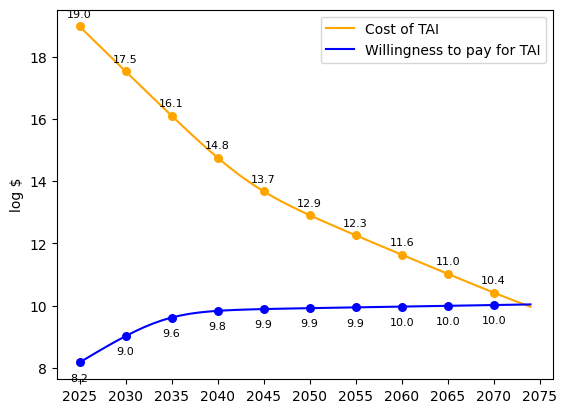

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 26.3 log FLOP (~199.5 septillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~26.4 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~464.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~309.2 million).
* This doubles every 1.1 year to a max of 0.055188% of GDP (initially ~13.9 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 26.3 logFLOP which costs 6.9 log 2025$USD to buy vs. WTP at 8.5 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 5 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured

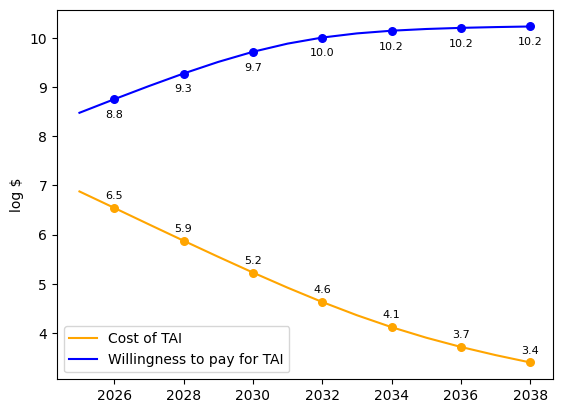

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 37.9 log FLOP (~79.4 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.6 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~23.4 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 1.5 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 37.9 logFLOP which costs 19.1 log 2025$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 37.5 logFLOP which costs 18.6 log 2025$USD to buy vs. WTP at 9.1 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 37.1 logFLOP which costs 18.1 log 2025$USD to buy vs. WTP at 9.3 (buys 28.3 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 36.7 logFLOP which c

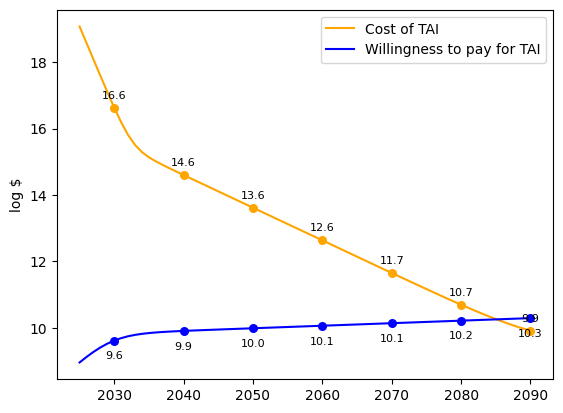

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 58.6 log FLOP (~39.8 septillion decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2.2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.9 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~202.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~301.3 million).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.4 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 58.6 logFLOP which costs 40.0 log 2025$USD to buy vs. WTP at 8.5 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 58.2 logFLOP which costs 39.5 log 2025$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 57.8 logFLOP which costs 38.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.7 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 57.4 logFLOP 

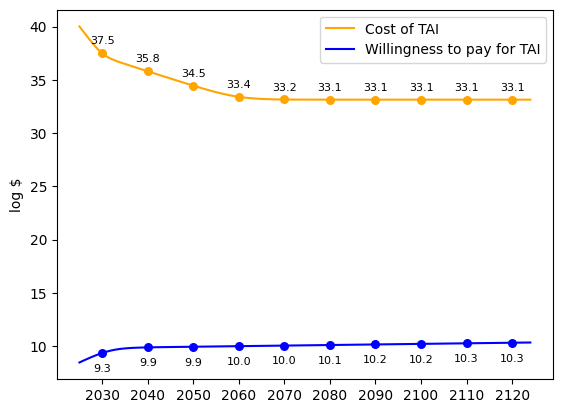

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 29.9 log FLOP (~794.3 octillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~28.1 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~11.4 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~609.1 million).
* This doubles every 3.4 year to a max of 0.069656% of GDP (initially ~17.6 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 29.9 logFLOP which costs 10.5 log 2025$USD to buy vs. WTP at 8.8 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 29.7 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 8.9 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 29.6 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 8.9 (buys 28.6 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 29.4 logFLOP which cost

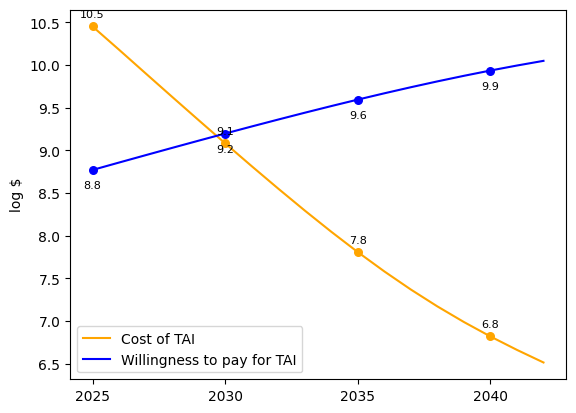

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 33.4 log FLOP (~2.5 decillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~18.3 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.8 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~922.5 million).
* This doubles every 2.4 year to a max of 0.047195% of GDP (initially ~11.9 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 33.4 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 33.3 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 9.0 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 33.1 logFLOP which costs 13.6 log 2025$USD to buy vs. WTP at 9.2 (buys 28.6 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 33.0 logFLOP which costs

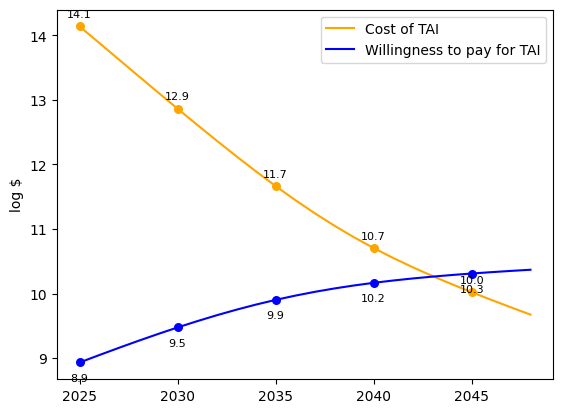

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 30.4 log FLOP (~2.5 nonillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.3 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~15.7 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~863.0 million).
* This doubles every 2.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.009x per year.
---
2025 - TAI takes 30.4 logFLOP which costs 11.8 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 30.2 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 30.0 logFLOP which costs 11.1 log 2025$USD to buy vs. WTP at 9.1 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 29.8 logFLOP which costs 10.

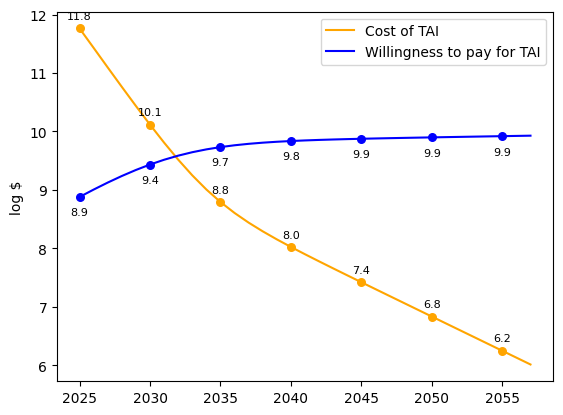

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 39.9 log FLOP (~7.9 million decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~15.4 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~12.1 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~390.2 million).
* This doubles every 1.6 year to a max of 0.077994% of GDP (initially ~19.7 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 39.9 logFLOP which costs 20.7 log 2025$USD to buy vs. WTP at 8.6 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 39.5 logFLOP which costs 20.2 log 2025$USD to buy vs. WTP at 8.8 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 39.2 logFLOP which costs 19.7 log 2025$USD to buy vs. WTP at 9.0 (buys 28.4 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 38.8 logFLOP whi

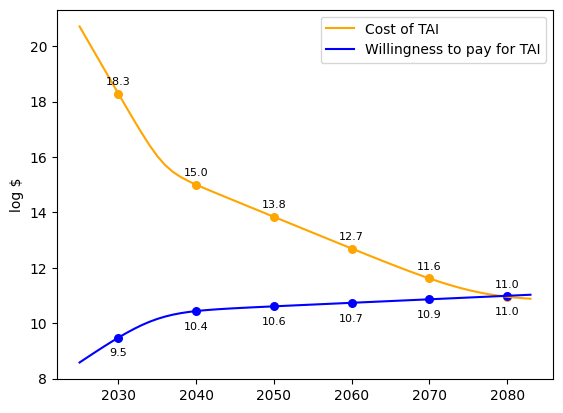

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 37.6 log FLOP (~39.8 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.5 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~668.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~198.4 million).
* This doubles every 1.1 year to a max of 0.142545% of GDP (initially ~35.8 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 37.6 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 8.3 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 37.2 logFLOP which costs 18.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.4 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 36.8 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.8 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 36.4 logFLOP 

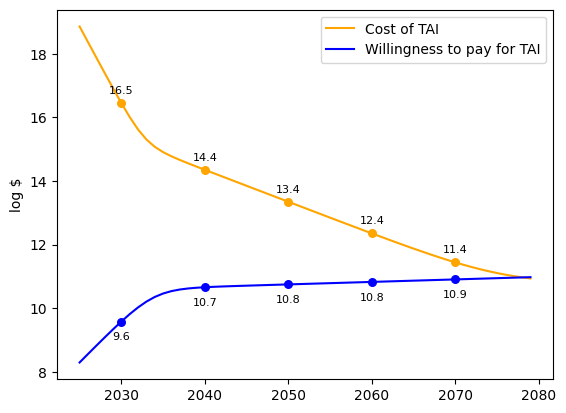

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 31.5 log FLOP (~31.6 nonillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.5 log FLOP (~28.2 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.3 log FLOP (~21.9 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~374.4 million).
* This doubles every 1.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 31.5 logFLOP which costs 12.0 log 2025$USD to buy vs. WTP at 8.5 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 31.3 logFLOP which costs 11.7 log 2025$USD to buy vs. WTP at 8.7 (buys 28.3 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 31.1 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 8.9 (buys 28.6 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 30.8 logFLOP which costs 1

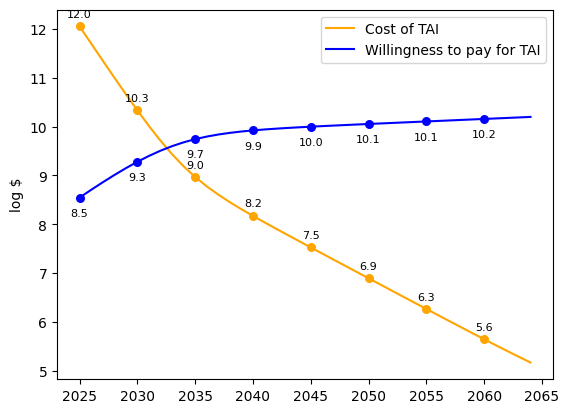

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 26.6 log FLOP (~398.1 septillion) for transformative capabilities.
* Every 2.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~56.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~573.0 million).
* This doubles every 1.1 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 26.6 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Non

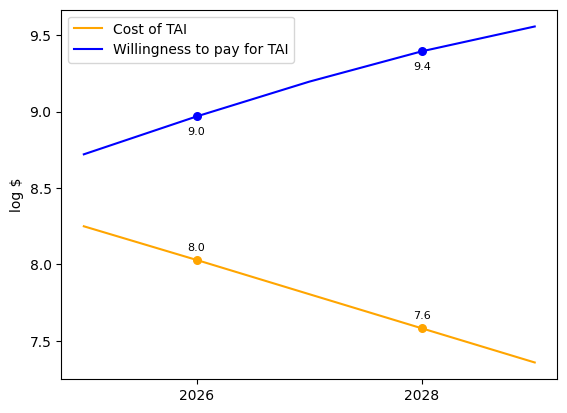

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 26.1 log FLOP (~125.9 septillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~384.4 million).
* This doubles every 2.0 year to a max of 0.044149% of GDP (initially ~11.2 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 26.1 logFLOP which costs 7.9 log 2025$USD to buy vs. WTP at 8.6 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 8 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
--

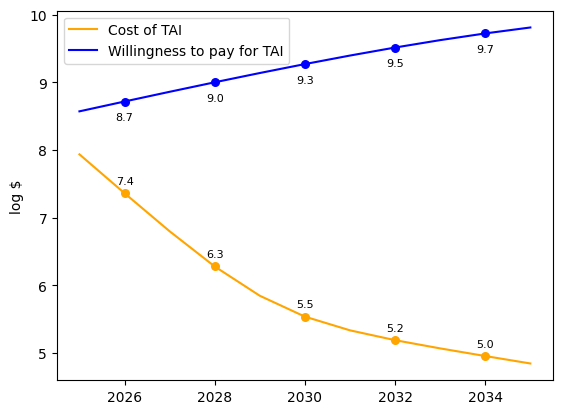

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.2 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~5.9 septillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~156.6 million).
* This doubles every 1.6 year to a max of 0.052462% of GDP (initially ~13.2 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 27.2 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 8.2 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 27.0 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 8.4 (buys 27.2 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1923 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.4734 -> Nonscaling delay occured
-- -- this delay is 4 years (

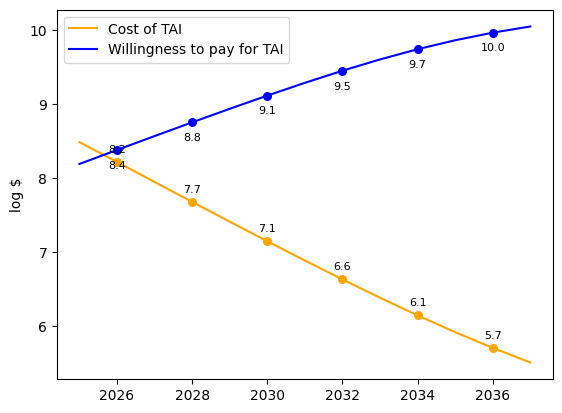

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 36.5 log FLOP (~3.2 thousand decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.1 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.7 septillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~154.6 million).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 36.5 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 8.2 (buys 26.2 log FLOP or 26.2 2025-log-eFLOP)
2026 - TAI takes 36.0 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 8.4 (buys 26.5 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 35.5 logFLOP which costs 17.3 log 2025$USD to buy vs. WTP at 8.6 (buys 26.8 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 35.1 logFLOP which c

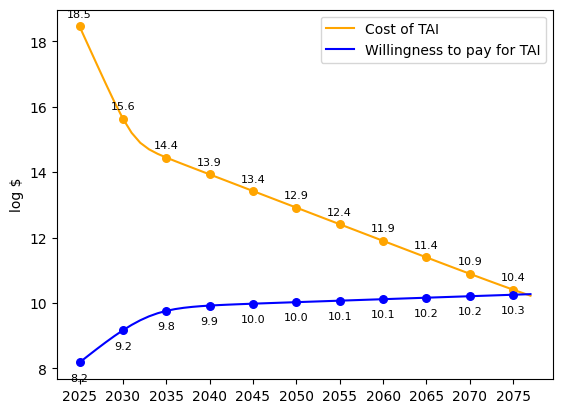

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 29.1 log FLOP (~125.9 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.2 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~11.5 septillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~154.6 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 29.1 logFLOP which costs 10.5 log 2025$USD to buy vs. WTP at 8.2 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 28.9 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 8.3 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 28.7 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 8.5 (buys 27.4 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 28.5 logFLOP which costs 9.

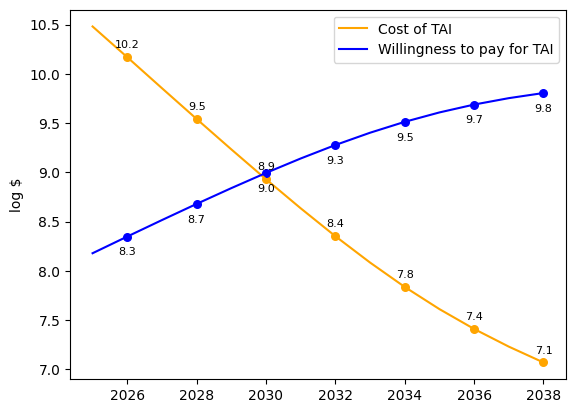

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 32.2 log FLOP (~158.5 nonillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.7 log FLOP (~50.3 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 27.0 log FLOP (~951.1 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 2.2 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 32.2 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 9.0 (buys 28.7 log FLOP or 28.7 2025-log-eFLOP)
2026 - TAI takes 32.0 logFLOP which costs 12.2 log 2025$USD to buy vs. WTP at 9.1 (buys 28.9 log FLOP or 29.1 2025-log-eFLOP)
2027 - TAI takes 31.8 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 9.2 (buys 29.1 log FLOP or 29.5 2025-log-eFLOP)
2028 - TAI takes 31.6 logFLOP which costs 1

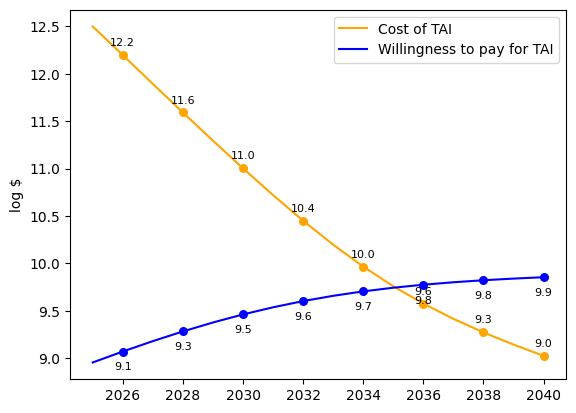

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 36.5 log FLOP (~3.2 thousand decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.3 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~113.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~464.8 million).
* This doubles every 2.0 year to a max of 0.025566% of GDP (initially ~6.4 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 36.5 logFLOP which costs 17.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 36.0 logFLOP which costs 16.8 log 2025$USD to buy vs. WTP at 8.8 (buys 28.0 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 35.5 logFLOP which costs 16.1 log 2025$USD to buy vs. WTP at 8.9 (buys 28.3 log FLOP or 29.3 2025-log-eFLOP)
2028 - TAI takes 35.0 logFLOP w

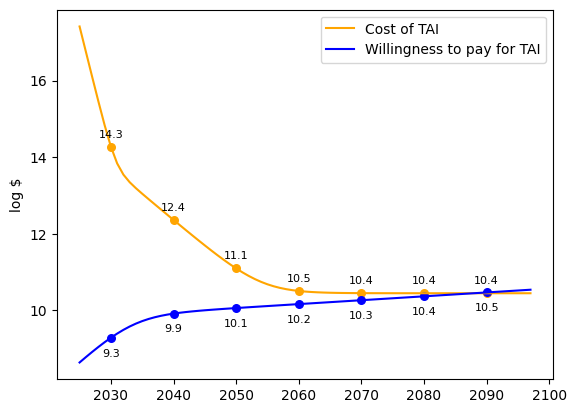

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 37.7 log FLOP (~50.1 thousand decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.7 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~193.4 million).
* This doubles every 1.6 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 37.7 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 8.3 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 37.4 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 8.5 (buys 27.3 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 37.0 logFLOP which costs 18.0 log 2025$USD to buy vs. WTP at 8.6 (buys 27.6 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 36.7 logFLOP which 

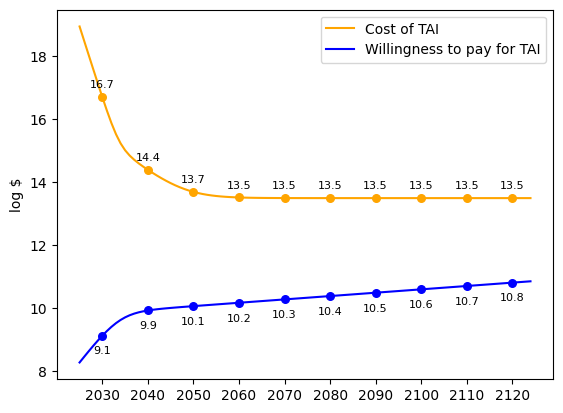

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 29.9 log FLOP (~794.3 octillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.5 log FLOP (~32.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~18.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 2.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 29.9 logFLOP which costs 10.4 log 2025$USD to buy vs. WTP at 9.1 (buys 28.6 log FLOP or 28.6 2025-log-eFLOP)
2026 - TAI takes 29.7 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 9.2 (buys 28.8 log FLOP or 29.0 2025-log-eFLOP)
2027 - TAI takes 29.6 logFLOP which costs 9.8 log 2025$USD to buy vs. WTP at 9.3 (buys 29.0 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 29.4 logFLOP which costs 9.6

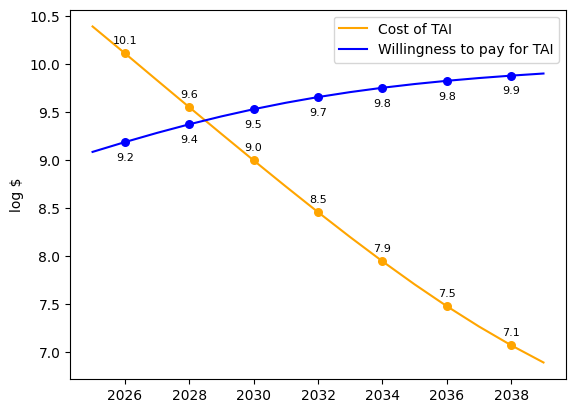

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 29.4 log FLOP (~251.2 octillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.7 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~53.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.1 billion).
* This doubles every 1.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 29.4 logFLOP which costs 10.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.4 log FLOP or 28.4 2025-log-eFLOP)
2026 - TAI takes 29.2 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 9.4 (buys 28.7 log FLOP or 28.8 2025-log-eFLOP)
2027 - TAI takes 29.1 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 9.5 (buys 28.9 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 28.9 logFLOP which costs 9.5

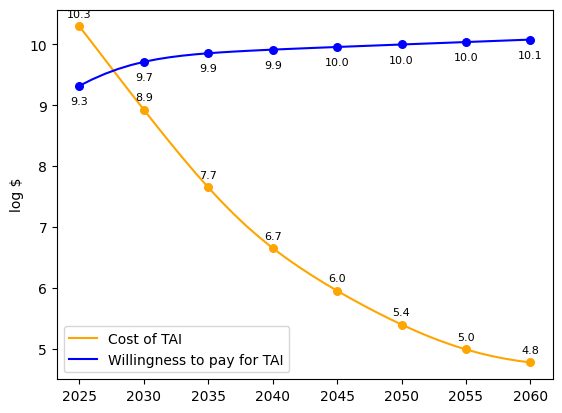

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 27.4 log FLOP (~2.5 octillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.6 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~105.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.5 million).
* This doubles every 2.2 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 27.4 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.4 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 27.2 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 8.5 (buys 27.4 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1923 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.4734 -> Nonscaling issue did not occur
-- data p_nonscaling_issu

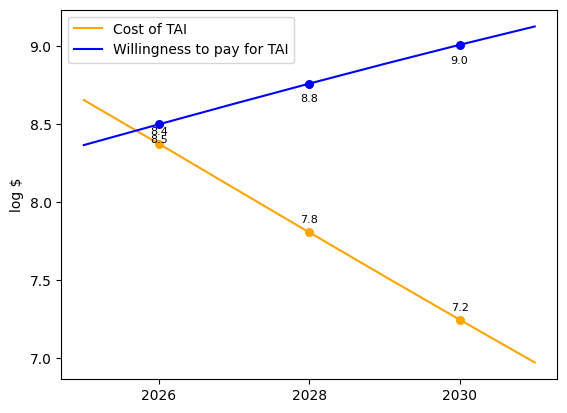

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 31.7 log FLOP (~50.1 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~821.3 quadrillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.3 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~465.7 million).
* This doubles every 1.1 year to a max of 0.02622% of GDP (initially ~6.6 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 31.7 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 8.6 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 31.4 logFLOP which costs 13.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 31.1 logFLOP which costs 12.9 log 2025$USD to buy vs. WTP at 9.1 (buys 27.3 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 30.8 logFLOP which costs

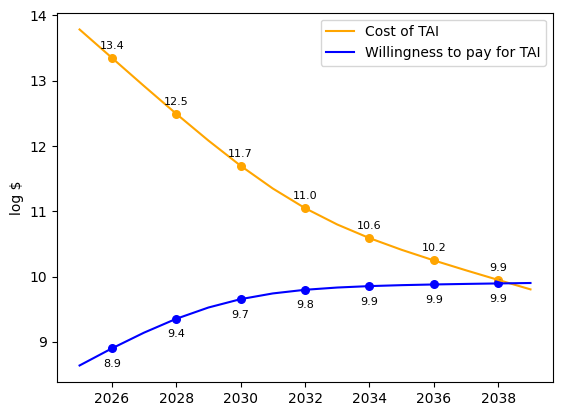

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 25.7 log FLOP (~50.1 septillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2025$USD.
* Every 3.3 years they get 2x cheaper, to a maximum of 25.3 log FLOP (~20.1 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.4 billion).
* This doubles every 2.2 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 25.7 logFLOP which costs 7.3 log 2025$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 3 years)
--

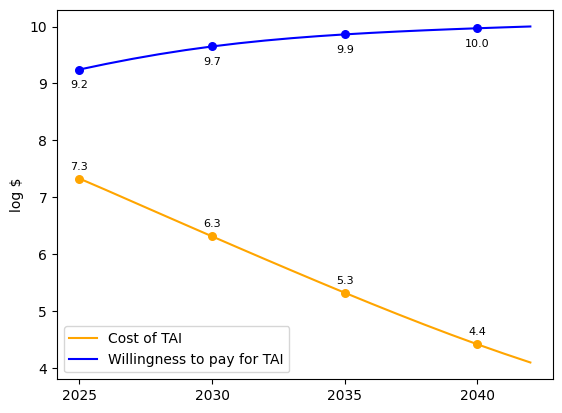

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 39.1 log FLOP (~1.3 million decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.8 quintillion) per 2025$USD.
* Every 1.6 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~137.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~484.8 million).
* This doubles every 1.1 year to a max of 0.058762% of GDP (initially ~14.8 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 39.1 logFLOP which costs 20.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 38.8 logFLOP which costs 19.9 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 38.5 logFLOP which costs 19.4 log 2025$USD to buy vs. WTP at 9.2 (buys 28.3 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 38.2 logFLOP wh

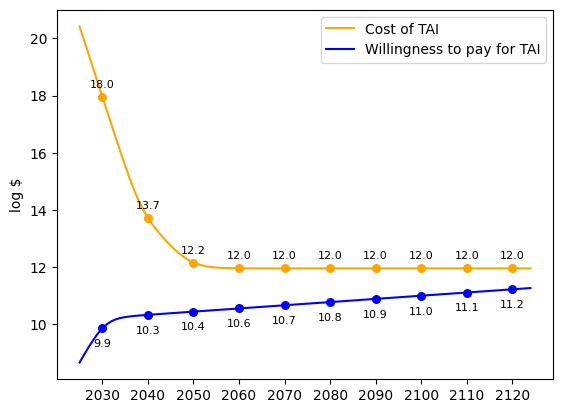

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 34.4 log FLOP (~25.1 decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.8 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.3 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~474.2 million).
* This doubles every 1.3 year to a max of 0.035112% of GDP (initially ~8.8 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 34.4 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 34.1 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 33.7 logFLOP which costs 14.7 log 2025$USD to buy vs. WTP at 9.1 (buys 28.1 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 33.4 logFLOP which costs 

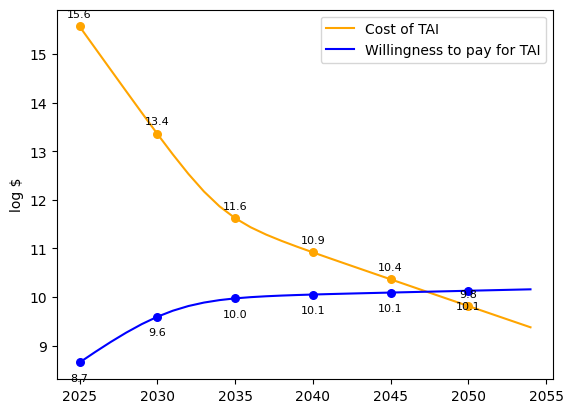

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 36.9 log FLOP (~7.9 thousand decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~852.1 quintillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~784.1 million).
* This doubles every 1.3 year to a max of 0.244907% of GDP (initially ~61.0 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 36.9 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 36.6 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 9.1 (buys 28.3 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 36.4 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 9.4 (buys 28.7 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 36.1 logFLOP

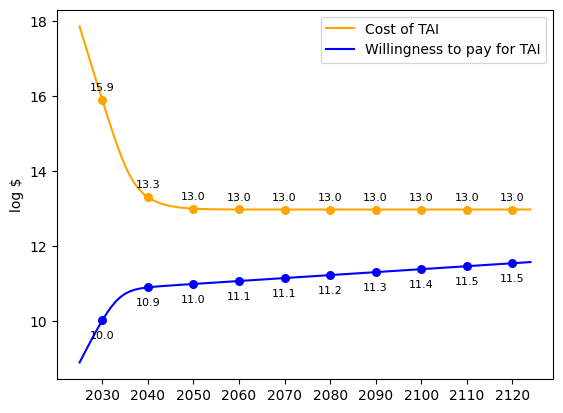

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 31.9 log FLOP (~79.4 nonillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.6 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 20.5 log FLOP (~299.0 quintillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~124.1 million).
* This doubles every 2.2 year to a max of 0.03522% of GDP (initially ~8.9 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 31.9 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 8.1 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 31.6 logFLOP which costs 12.6 log 2025$USD to buy vs. WTP at 8.2 (buys 27.1 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 31.2 logFLOP which costs 12.2 log 2025$USD to buy vs. WTP at 8.4 (buys 27.4 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 30.9 logFLOP which cost

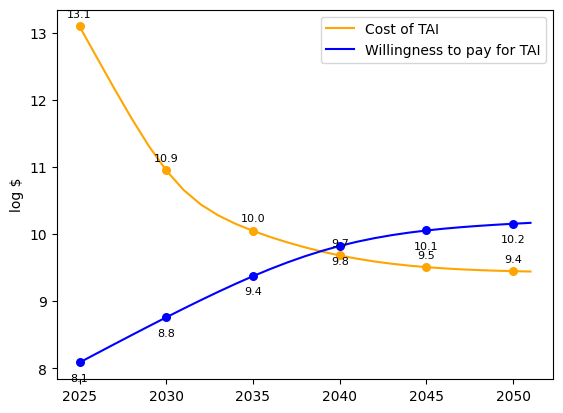

In [14]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [15]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-04-11 14:04:02.820379
